# BAO examples

In this notebook we will show how to perform BAO fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
pk = cosmo.get_fourier().pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = cosmo.growth_rate(z)
shotnoise = 1 / 5e-4
volume = 1e10

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1001):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

## BAO likelihood

In [2]:
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, DampedBAOWigglesTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import setup_logging


template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI')
theory = DampedBAOWigglesTracerPowerSpectrumMultipoles(template=template)
# Set damping sigmas to zero, as data follows linear pk
for param in theory.params.select(basename='sigma*'):
    param.update(value=0., fixed=True) 
# Fix some broadband parameters (those with k^{-3} and k^{-2}) to speed up calculation in this notebook
for param in theory.params.select(basename=['al*_-3', 'al*_-2']):
    param.update(value=0., fixed=True)
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=mocks,
                                                     klim={0: [0.005, 0.2], 2: [0.005, 0.2]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

setup_logging()

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [3]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 3 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiler.maximize(niterations=3)

[000000.15] [0/1] 03-30 20:56  ObservablesGaussianLikelihood INFO     Covariance matrix with 40 points built from 1000 observations.
[000000.16] [0/1] 03-30 20:56  ObservablesGaussianLikelihood INFO     ...resulting in Hartlap factor of 0.9590.
[000000.53] [0/1] 03-30 20:56  MinuitProfiler            INFO     Varied parameters: ['qpar', 'qper', 'b1', 'al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


In [4]:
print(profiler.profiles.to_stats(tablefmt='pretty'))

+-------------------------------------+--------+---------+--------+
| chi2 / (40 - 9) = 23.18 / 31 = 0.75 | varied | bestfit | error  |
+-------------------------------------+--------+---------+--------+
|                qpar                 |  True  | 1.0014  | 0.0027 |
|                qper                 |  True  | 0.9955  | 0.0049 |
|                 b1                  |  True  |  1.977  | 0.023  |
|               al0_-1                |  True  |   190   |  160   |
|                al0_0                |  True  |   -80   |  240   |
|                al0_1                |  True  |   24    |  100.  |
|               al2_-1                |  True  |   33    |  60.   |
|                al2_0                |  True  |  -109   |   99   |
|                al2_1                |  True  |   46    |  40.   |
+-------------------------------------+--------+---------+--------+


array([<AxesSubplot:ylabel='$q_{\\parallel}$'>,
       <AxesSubplot:ylabel='$q_{\\perp}$'>], dtype=object)

[000033.69] [0/1] 03-30 20:56  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000033.69] [0/1] 03-30 20:56  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000033.73] [0/1] 03-30 20:56  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000033.73] [0/1] 03-30 20:56  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


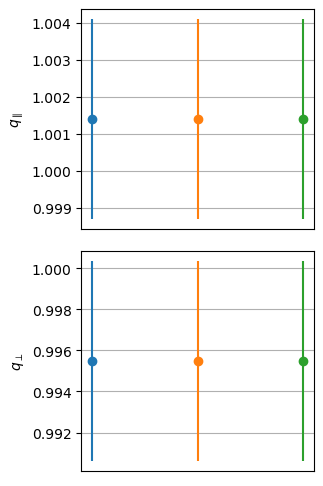

In [5]:
from desilike.samples import plotting
plotting.plot_aligned_stacked(profiler.profiles, params=['qpar', 'qper'])

array([<AxesSubplot:ylabel='$k \\Delta P_{0}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>,
       <AxesSubplot:xlabel='$k$ [$h/\\mathrm{Mpc}$]', ylabel='$k \\Delta P_{2}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>],
      dtype=object)

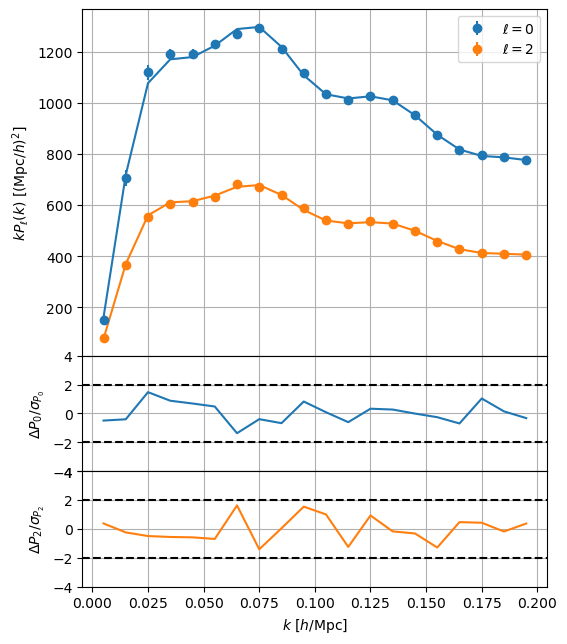

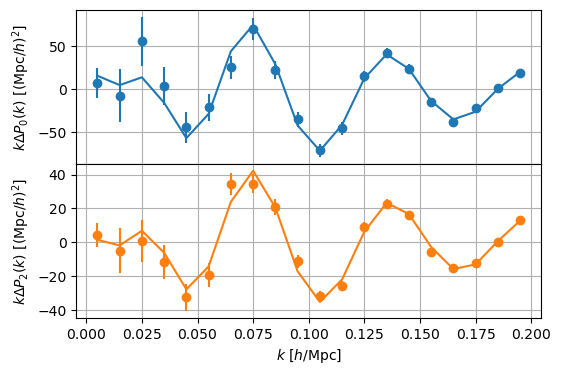

In [6]:
likelihood(**profiler.profiles.bestfit.choice(params=likelihood.varied_params))
observable.plot()
observable.plot_wiggles()

## Detection level

In [7]:
likelihood()
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qiso', only_now=True)
theory.init.update(template=template)

profiler = MinuitProfiler(likelihood, seed=42)
grid = np.linspace(0.8, 1.2, 31)
profiler.maximize(niterations=1)
profiler.profile(params=['qiso'], grid=grid)
profiles_nowiggle = profiler.profiles

[000034.75] [0/1] 03-30 20:56  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1', 'al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


In [8]:
template.init.update(only_now=False)

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
print(profiler.profiles.to_stats(tablefmt='pretty'))

profiler.profile(params=['qiso'], grid=grid)
profiles = profiler.profiles

[000207.50] [0/1] 03-30 20:59  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1', 'al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].
+-------------------------------------+--------+---------+--------+
| chi2 / (40 - 8) = 25.96 / 32 = 0.81 | varied | bestfit | error  |
+-------------------------------------+--------+---------+--------+
|                qiso                 |  True  | 1.0025  | 0.0027 |
|                 b1                  |  True  |  1.995  | 0.020  |
|               al0_-1                |  True  |   180   |  160   |
|                al0_0                |  True  |  -230   |  220   |
|                al0_1                |  True  |   88    |   94   |
|               al2_-1                |  True  |   53    |   58   |
|                al2_0                |  True  |   -38   |  90.   |
|                al2_1                |  True  |   14    |   36   |
+-------------------------------------+--------+---------+--------+


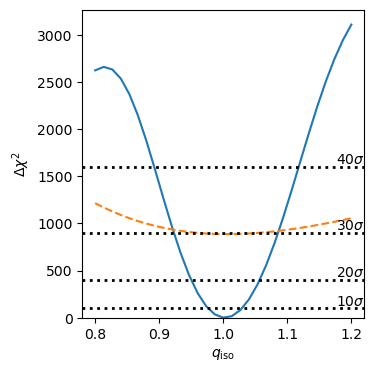

In [9]:
plotting.plot_profile_comparison(profiles, profiles_nowiggle, cl=[10, 20, 30, 40])
# Orange curve, which is no-wiggle, is not flat:
# some qiso information is picked up by the broadband because we did not include enough broadband terms

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [10]:
from desilike.samplers import ZeusSampler

theory = DampedBAOWigglesTracerPowerSpectrumMultipoles(template=template)
# Fix some broadband parameters (those with k^{-3}, k^{-2} and k^{-1}) to speed up inference in this notebook
for param in theory.params.select(basename=['al*_-3', 'al*_-2', 'al*_-1']):
    param.update(value=0., fixed=True)
observable.init.update(theory=theory)

sampler = ZeusSampler(likelihood, save_fn='_tests/chain_bao_*.npy', seed=42)
sampler.run(check={'max_eigen_gr': 0.1, 'stable_over': 1})

[000388.50] [0/1] 03-30 21:02  ZeusSampler               INFO     Varied parameters: ['qiso', 'b1', 'al0_0', 'al0_1', 'al2_0', 'al2_1'].
[000388.91] [0/1] 03-30 21:02  root                      INFO     Initialising ensemble of 16 walkers...
[000647.19] [0/1] 03-30 21:07  Chain                     INFO     Saving _tests/chain_bao_0.npy.
[000647.20] [0/1] 03-30 21:07  ZeusSampler               INFO     Diagnostics:
[000647.21] [0/1] 03-30 21:07  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 1.03; not < 0.1.
[000647.23] [0/1] 03-30 21:07  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0109.
[000647.83] [0/1] 03-30 21:07  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.178.
[000647.84] [0/1] 03-30 21:07  ZeusSampler               INFO     - max Geweke is 0.425.
[000647.84] [0/1] 03-30 21:07  ZeusSampler               INFO     - Geweke p-value is 0.0309.
[000647.87] [0/1] 03-30 21:07  ZeusSampler               INFO

[Chain(shape=(1500, 16), params=ParameterCollection(['qiso', 'b1', 'al0_0', 'al0_1', 'al2_0', 'al2_1', 'logposterior', 'df', 'sigmas', 'sigmapar', 'sigmaper', 'al0_-3', 'al0_-2', 'al0_-1', 'al2_-3', 'al2_-2', 'al2_-1', 'DM_over_rd', 'DH_over_rd', 'DH_over_DM', 'DV_over_rd', 'loglikelihood', 'logprior']))]

In [11]:
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+-------+--------+--------+--------+--------+-----------------+-----------------+
|       | argmax |  mean  | median |  std   | quantile:1sigma | interval:1sigma |
+-------+--------+--------+--------+--------+-----------------+-----------------+
| qiso  | 1.0078 | 1.0074 | 1.0075 | 0.0038 | -0.0037/+0.0037 | -0.0038/+0.0036 |
|  b1   | 2.072  | 2.069  | 2.069  | 0.019  |  -0.019/+0.019  |  -0.019/+0.018  |
| al0_0 | -1090  | -1060  | -1060  |  230   |    -230/+230    |    -250/+220    |
| al0_1 |  475   |  462   |  462   |   99   |    -99/+100.    |    -98/+101     |
| al2_0 |  -266  |  -264  |  -264  |   52   |     -52/+53     |     -51/+53     |
| al2_1 |  128   |  127   |  128   |   24   |     -25/+24     |     -27/+22     |
+-------+--------+--------+--------+--------+-----------------+-----------------+


[001746.18] [0/1] 03-30 21:25  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in


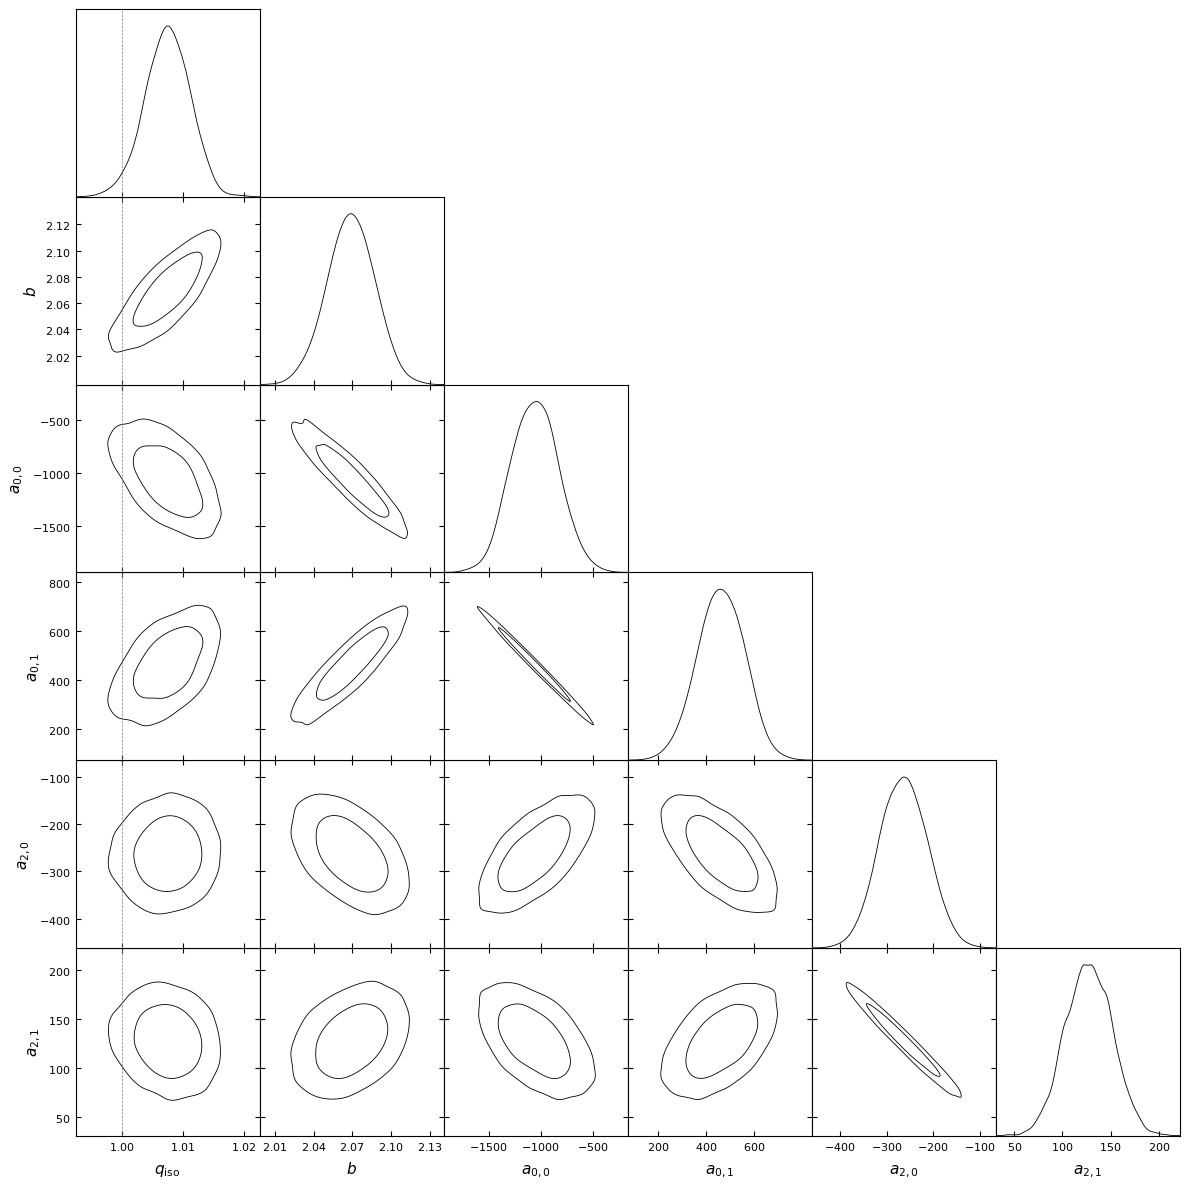

In [12]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'qiso': 1.})